# Import necessary modules

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

import cv2 # computer vision
import os
import numpy as np
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls

# CNN Model

File Path

In [4]:
# defining global variable path
# Location of my dataset on My Google Drive
image_path = "drive/MyDrive/train"

In [5]:
#data_path = r'C:\Users\ataca\OneDrive\MSCS Classes\Summer 2022\DS Capstone\My_Capstone_Project\images'

# Assigning values for parameters

In [6]:
batch_size = 50
rand_seed = 42
color_mode = "rgb"  # make sure images is colored with 3 channels: red, green, blue
number_color_layers = 3
image_size = (100, 100)
image_shape = image_size + (number_color_layers,)

In [7]:
tf.random.set_seed(rand_seed)

# Load Train and Validation Data

In [8]:
# Training set
train_set = tf.keras.preprocessing.image_dataset_from_directory(image_path, validation_split=0.2, subset= "training", color_mode=color_mode,
                                                                seed=rand_seed, image_size= image_size, batch_size=batch_size)

Found 2654 files belonging to 2 classes.
Using 2124 files for training.


In [9]:
# validation set
valid_set = tf.keras.preprocessing.image_dataset_from_directory(image_path, validation_split=0.2, subset= "validation", color_mode=color_mode,
                                                                seed=rand_seed, image_size= image_size, batch_size=batch_size)

Found 2654 files belonging to 2 classes.
Using 530 files for validation.


In [10]:
type(train_set)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [11]:
type(valid_set)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [12]:
class_names = train_set.class_names
class_names

['Autistic', 'Non_Autistic']

In [13]:
for image_batch, labels_batch in train_set:
    print("image batch: ", image_batch.shape)
    print("labels_batch: ", labels_batch.shape)
    break

image batch:  (200, 100, 100, 3)
labels_batch:  (200,)


# Show sample images from train_set with labels

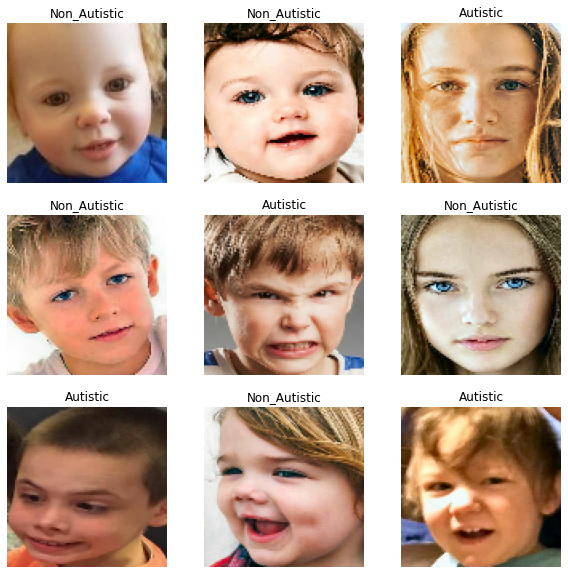

In [14]:
# plot sample images along with created labels
plt.figure(figsize=(10,10))
for images, labels in train_set.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [15]:
# Configure images for better performance
AUTOTUNE = tf.data.AUTOTUNE

# cache() keeps the images in memory after they're loaded off disk during the first epoch
# this ensures dataset does not become bottleneck while training the model
# prefetch() to overlap data preprocessing and model execution while trianing
train_set = train_set.cache().prefetch(buffer_size=AUTOTUNE)

# Augment images from existing ones to increase data size

In [16]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),])

# Build model

In [17]:
model_cnn = tf.keras.models.Sequential([data_augmentation])
model_cnn.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255))         # standardize RGB channel values from values [0 - 255] to [0-1]
model_cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(2, 2), activation='relu', padding='same', input_shape=(100, 100, 3)))  # Input layer
model_cnn.add(tf.keras.layers.MaxPool2D())

model_cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(2, 2), activation='relu', padding='same'))
model_cnn.add(tf.keras.layers.MaxPool2D())
model_cnn.add(tf.keras.layers.Dropout(0.2))

model_cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(2, 2), activation='relu', padding='same'))
model_cnn.add(tf.keras.layers.MaxPool2D())
model_cnn.add(tf.keras.layers.Dropout(0.2))

model_cnn.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(2, 2), activation='relu', padding='same'))
model_cnn.add(tf.keras.layers.MaxPool2D())
model_cnn.add(tf.keras.layers.Dropout(0.2))

model_cnn.add(tf.keras.layers.Flatten())

model_cnn.add(tf.keras.layers.Dense(units = 512, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(units = 2, activation='sigmoid'))

In [18]:
loss_function = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=loss_function, metrics=['accuracy'])  # lower lr

# Train model

In [19]:
# Define early_stopping_monitor to avoid overfitting
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(monitor = 'val_loss', mode = 'auto', patience=2, restore_best_weights=True)

In [23]:
cnn_model = model_cnn.fit(train_set, batch_size=batch_size, epochs=80, shuffle=True, validation_data=valid_set, callbacks=[early_stopping_monitor])

Epoch 1/80


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


11/11 [==============================] - 9s 241ms/step - loss: 0.6934 - accuracy: 0.5250 - val_loss: 0.6873 - val_accuracy: 0.5547
Epoch 2/80
11/11 [==============================] - 2s 169ms/step - loss: 0.6824 - accuracy: 0.5838 - val_loss: 0.6801 - val_accuracy: 0.5679
Epoch 3/80
11/11 [==============================] - 2s 162ms/step - loss: 0.6767 - accuracy: 0.5791 - val_loss: 0.6708 - val_accuracy: 0.5774
Epoch 4/80
11/11 [==============================] - 2s 165ms/step - loss: 0.6667 - accuracy: 0.5862 - val_loss: 0.6553 - val_accuracy: 0.6472
Epoch 5/80
11/11 [==============================] - 2s 165ms/step - loss: 0.6538 - accuracy: 0.6106 - val_loss: 0.6374 - val_accuracy: 0.6755
Epoch 6/80
11/11 [==============================] - 2s 167ms/step - loss: 0.6357 - accuracy: 0.6365 - val_loss: 0.6185 - val_accuracy: 0.6717
Epoch 7/80
11/11 [==============================] - 2s 164ms/step - loss: 0.6179 - accuracy: 0.6516 - val_loss: 0.6115 - val_accuracy: 0.6453
Epoch 8/80
11/11 

In [24]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 100, 100, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                  

# Plot to compare training and validation results

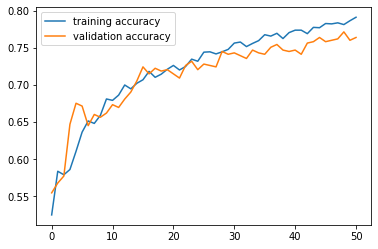

In [25]:
# Plot accuracy of training and validation data
plt.plot(cnn_model.history['accuracy'], label = 'training accuracy')
plt.plot(cnn_model.history['val_accuracy'], label = 'validation accuracy')
plt.legend()

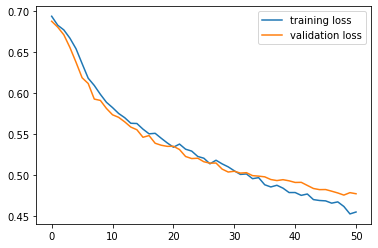

In [26]:
# Plot loss of training and validation data
plt.plot(cnn_model.history['loss'], label = 'training loss')
plt.plot(cnn_model.history['val_loss'], label = 'validation loss')
plt.legend()

# Save Model

In [27]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model_cnn.save('my_cnn_model_56.h5')

# Load Model

In [28]:
# Recreate the exact same model, including its weights and the optimizer
cnn_model = tf.keras.models.load_model('my_cnn_model_56.h5')

# Show the model architecture
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 100, 100, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                  

# Loading Test Data

In [29]:
#test_path = r'C:\Users\ataca\OneDrive\MSCS Classes\Summer 2022\DS Capstone\My_Capstone_Project\test'
test_path = "drive/MyDrive/test"
# test set
test_set = tf.keras.preprocessing.image_dataset_from_directory(test_path, validation_split=None, subset= None, color_mode=color_mode,
                                                                seed=rand_seed, image_size=image_size, batch_size=batch_size)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

Found 280 files belonging to 2 classes.


In [30]:
type(test_set)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

# Model Predictions

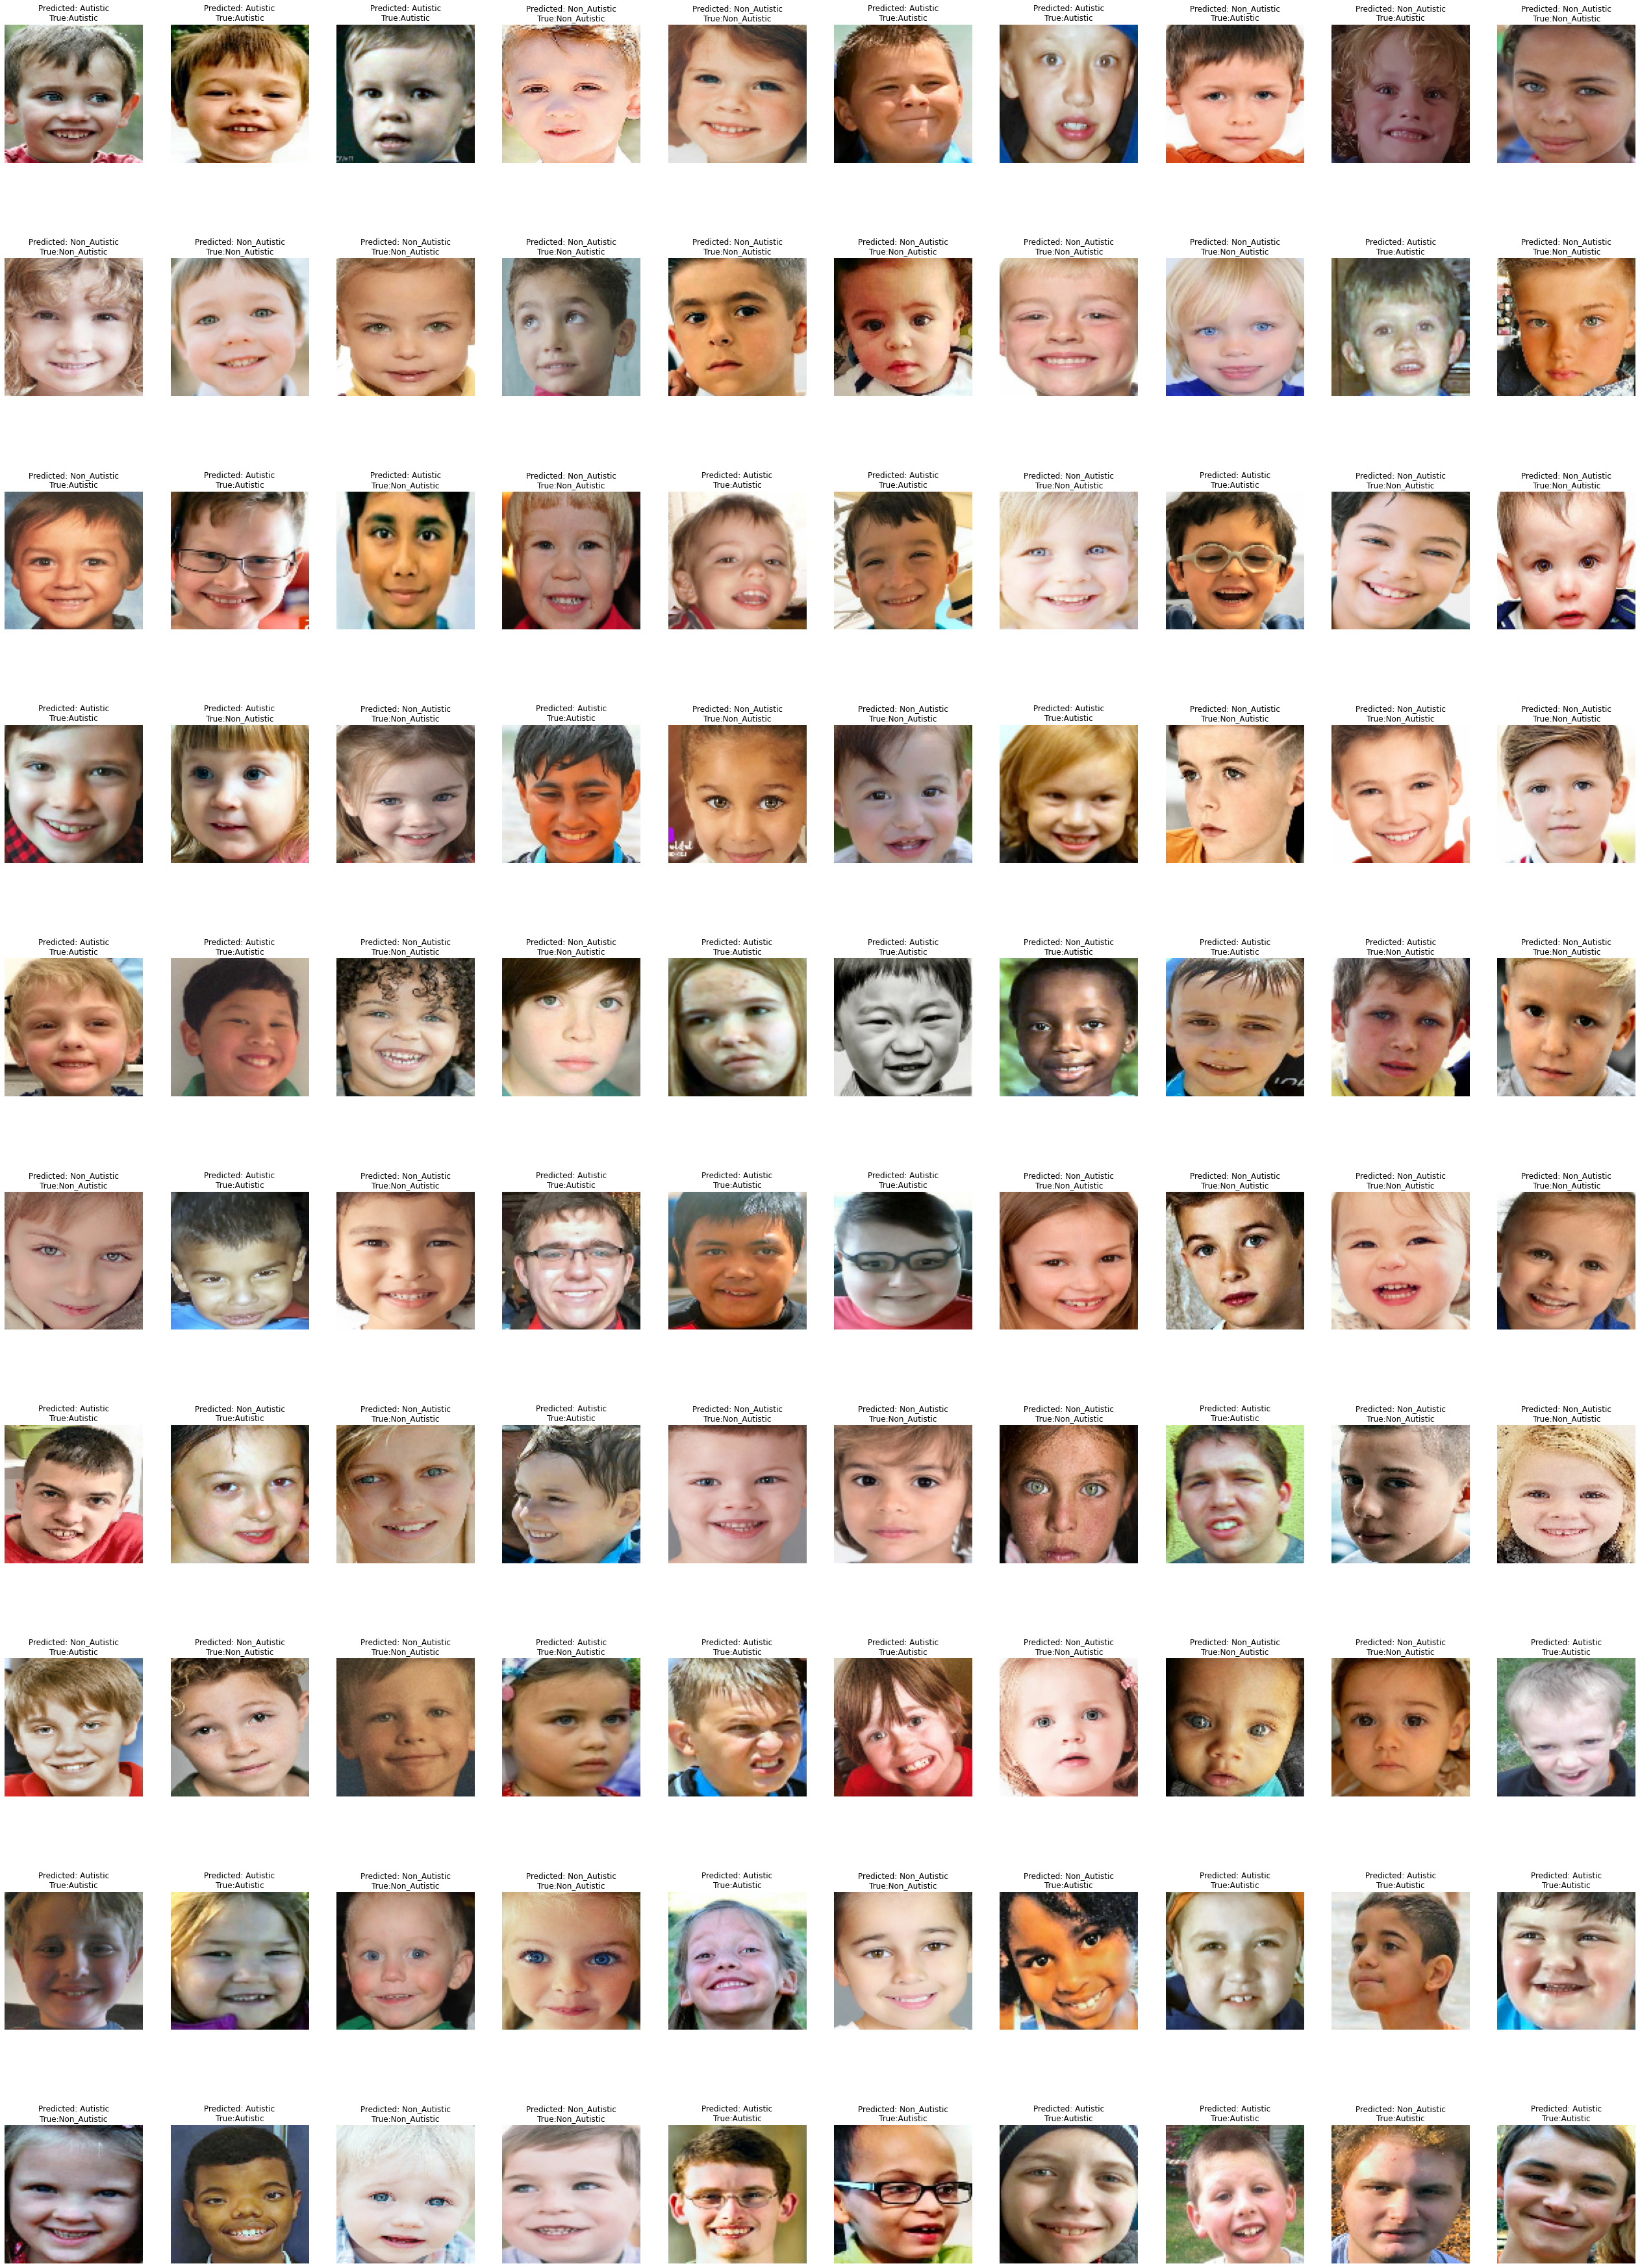

In [31]:
plt.figure(figsize=(45, 65))
for images, labels in test_set.take(1):
    predictions = cnn_model.predict(images)
    predlabel = []
    
    for pred in predictions:
        predlabel.append(class_names[np.argmax(pred)])
    
    for i in range(50):
        ax = plt.subplot(5, 10, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Predicted: '+ predlabel[i] + '\nTrue:' + class_names[labels[i]])  # shows prediction and true labels
        plt.axis('off')
        plt.grid(True)

# Model Evaluation

In [32]:
model_cnn.evaluate(test_set)

2/2 [==============================] - 0s 58ms/step - loss: 0.3381 - accuracy: 0.8643


[0.3381214439868927, 0.8642857074737549]

In [1]:
# Computation done manually
TP, TN, FP, FN = 39, 47, 5, 9

recall = TP / (TP + FN) * 100
print("Recall: %.2f" % recall)

precision = TP / (TP + FP) * 100
print("Precision: %.2f" % precision)

specificity = TN / (TN + FP) * 100
print("Specificity: %.2f" % specificity)

f1_score = 2 * (precision * recall)/(precision + recall)
print("F1 Score: %.2f" % f1_score)

Recall: 81.25
Precision: 88.64
Specificity: 90.38
F1 Score: 84.78


# Summary:

This model performed much better than the first 55 ones.
When changing the image size either higher or smaller impacted the performance: increasing blurs the image while decreasing made it clearer, however, the model seems to have a not detect and extract other important features.
The learning rate and the batch size affect the performance as well. The combination of batch size = 50 and learning rate of 0.0001 produced the best model in this case.
The input layer has 32 filters.
There are 3 Conv2D layers with 64, 128, and 256 filters respectively, kernel size used is 2x2, padding = same, and activation = relu.
I also implemented a MaxPool layer after each convolutional layer, and a Dropout layer at 20% each.
The last dropout layer is followed with a flattening layer.
I also added 1 Dense layer with 512 neurons prior to the output layer. This has an activation function of relu.
The output layer, also a dense layer, has 2 neurons which is equal to the number of classes.
There is some overfitting but is not terrible.
I would like to see if some hyperparameter tuning will improve the model, and this will be done in AWS Sagemaker.

In [ ]:
[0 1 1 0 0 0 1 1 0 0 1 0 0 1 1 0 0  0 1 1 0 1 0 0 1 0 1 0 1 1  1 0 1 0 1 0 0  0 1  1 ]

[0 1 1 0 0 0 1 1 0 0 1 0 0 1 1 0 0  1 1 1 0 1 0 0 1 0 1 0 1 1  0 0 1 0 1 0 0  1 1  0]

Tp = 19
Tn = 16
FP = 2
FN = 2

In [ ]:
[1  1 0 0 1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 1 1 0 1 1 0 0 0 1 1 1]
[0  1 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 0 0 1 0 1 1 0 1 0 1 1 0 1 0 1 1 1]

18,  18, 2, 2


In [ ]:
[0 0 1 1 0 1  1  1 1 1 0 0 0 1 0 0 0  0  1 0 0 1 0 0 0 0  1  1 0 1 1 1 0  0  1 1 1 0 1 0]
[0 0 1 1 0 1  0  1 1 1 0 0 0 1 0 0 0  1  1 0 0 1 0 0 0 0  0  1 0 1 1 1 0  1  1 1 1 0 1 0 ]

19, 17, 2, 2 

In [ ]:
[0 0 1 0 1 1 1 0 1 0 1 0 0 0 1 1 0 0  1  1 0 1  0  1  1  0 0 1 1 1 0 1 0  0  0 0 0 1 0 1]
[0 0 1 0 1 1 1 0 1 0 1 0 0 0 1 1 0 0  0  1 0 1  1  1  0  0 0 1 1 1 0 1 0  1  0 0 0 1 0 1]

19, 17, 2 , 2 

In [ ]:
[1 0 1 0 0 0 0 0 1 1 1 0 0  0  1 0 0 1  1  1 1 1 1 1 0 1 1 0 1  1  1 0 0 1 0 0 0 1  0  0]
[1 0 1 0 0 0 0 0 1 1 1 0 0  1  1 0 0 1  0  1 1 1 1 1 0 1 1 0 1  0  1 0 0 1 0 0 0 1  1  0]

18, 18, 2, 2

tensorflow-training-220904-0916-028-5342b26a